In [5]:
import os
# path for data 
os.environ["SPEDAS_DATA_DIR"] = "/Volumes/datadir/mmsdata" #"/Users/naah5403/data"

import pyspedas

In [6]:
import torch
from torch import nn

# Define the neural network
class MultiInputModel(nn.Module):
    def __init__(self):
        super(MultiInputModel, self).__init__()
        self.conv2d_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv2d_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv1d_1 = nn.Sequential(
            nn.Conv1d(in_channels=3,
                     out_channels=16,
                     kernel_size=3, # how big is the square that's going over the image?
                     stride=1, # default
                     padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,
                      out_channels=16*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm1d(num_features=16*2),
            nn.ReLU(),
        )

        self.conv1d_2 = nn.Sequential(
            nn.Conv1d(in_channels=16*2,
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2,
                         stride=2)
        )

        self.fc1 = nn.Linear(64*5*4, out_features=64)
        self.fc2 = nn.Linear(16*20, out_features=64)
        self.fc = nn.Linear(128, 6)
          
    def forward(self, x1, x2):
        # print(x1.shape)
        x1 = self.conv2d_1(x1)
        # print(x1.shape)
        x1 = self.conv2d_2(x1)
        x1 = self.conv2d_3(x1)
        # print(x1.shape)
        x1 = x1.view(x1.size(0), -1)  # Flatten hidden_units*10*8
        # print(x1.shape)
        x1 = self.fc1(x1)
        
        x2 = self.conv1d_1(x2)
        # print(x2.shape)
        x2 = self.conv1d_2(x2)
        # print(x2.shape)
        x2 = x2.view(x2.size(0), -1)  # Flatten hidden_units*20
        # print(x2.shape)
        x2 = self.fc2(x2)
        
        x = torch.cat((x1, x2), dim=1)  # Concatenate along feature dimension
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [7]:
# Instantiate a fresh instance of multiinputmodel
loaded_model = MultiInputModel()

from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "model01_fluxandBtTXsteps20.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Load model state dict 
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")

Loaded model:
MultiInputModel(
  (conv2d_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1d_1): Sequential(
    (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), pa

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools
import xarray as xr

# dayside use case
# trange = ['2019-11-09/00:05:00', '2019-11-09/23:59:00']
# trange = ['2019-12-07/00:05:00', '2019-12-07/23:59:00']
# trange = ['2022-01-09/00:00:00', '2022-01-09/23:59:00']
# trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']
# trange = ['2019-03-05/14:00:00', '2019-03-05/23:59:00']
# trange = ['2017-01-31/00:00:00', '2017-01-31/23:59:00']

## nightside use case
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
# trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']


## flank use case
trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

tname = trange[0].replace('/','_').replace('-','').replace(':','')

from pytplot import tplot, del_data, options, get_data, get, store_data, ylim, tplot_options, tlimit

probe = '1'
pyspedas.mms.fgm(trange=trange, data_rate='srvy', probe=probe)
pyspedas.mms.fpi(trange=trange,center_measurement=True, data_rate='fast',datatype=['dis-moms'], probe=probe)
pyspedas.mms.mec(trange=trange, data_rate='srvy', probe=probe)

BgseN ='mms1_fgm_b_gse_srvy_l2'
DeniN = 'mms1_dis_numberdensity_fast'
ViN = 'mms1_dis_bulkv_gse_fast'
TiperpN = 'mms1_dis_tempperp_fast'
TiparaN = 'mms1_dis_temppara_fast'
posN = 'mms1_mec_r_gse'

omni_flux = get_data('mms1_dis_energyspectr_omni_fast')
energy = get_data('mms1_dis_energy_fast')

# Interpol to ion fpi time 30ms
from pyspedas import tinterpol
tinterpol(BgseN, DeniN)
tinterpol(posN, DeniN)

#times, Bgse = get_data(BgseN+'-itrp')

ni = get_data(DeniN)
B = get_data(BgseN+'-itrp')
Vi = get_data(ViN)
Tiperp = get_data(TiperpN)
Tipara = get_data(TiparaN)
pos = get_data(posN+'-itrp')

from pyspedas import time_string
df_time = time_string(ni.times)
df_ni = pd.DataFrame(ni.y, columns = ['ni'],index = [df_time])
df_B = pd.DataFrame(B.y, columns = ['Bx','By','Bz','Btot'],index = [df_time])
df_Vi = pd.DataFrame(Vi.y, columns = ['Vx','Vy','Vz'],index = [df_time])
df_Vitot = pd.DataFrame(np.linalg.norm(df_Vi.values, axis=1), columns = ['vitot'], index = [df_time])
df_Tiperp = pd.DataFrame(Tiperp.y, columns = ['Tiperp'],index = [df_time])
df_Tipara = pd.DataFrame(Tipara.y, columns = ['Tipara'],index = [df_time])
df_Ti = pd.concat([df_Tiperp,df_Tipara], axis=1)
df_Titot = df_Ti.mean(axis=1)
df_pos = pd.DataFrame(pos.y/6378., columns = ['X','Y','Z'],index = [df_time])

df_final = pd.concat([df_B, df_ni, df_Vi, df_Vitot, df_Ti, df_Titot, df_pos], axis=1)
df_final.columns = ['bx', 'by', 'bz', 'btot', 'ni', 'vix', 'viy', 'viz', 'vitot', 'Tiperp', 'Tipara', 'Titot', 'X', 'Y', 'Z']
df_final.head()

09-Jul-25 17:06:45: Loading /Volumes/datadir/mmsdata/mms/mms1/fgm/srvy/l2/2015/09/mms1_fgm_srvy_l2_20150915_v4.18.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915060000_v3.4.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915080000_v3.4.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915100000_v3.4.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915120000_v3.4.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915140000_v3.4.0.cdf
09-Jul-25 17:06:49: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915160000_v3.4.0.cdf
09-Jul-25 17:06:49: Lo

,bx,by,bz,btot,ni,vix,viy,viz,vitot,Tiperp,Tipara,Titot,X,Y,Z
2015-09-15 06:50:02.373974,58.698201,20.293555,80.592210,101.746803,3.259999,-2.765188,-1.623854,4.575152,5.587056,1856.200684,1835.724121,1845.962402,5.635855,4.734723,0.273193
2015-09-15 06:50:06.873991,58.924944,20.456262,80.767787,102.049221,3.233701,-5.054675,-0.340348,5.683949,7.613990,1853.350708,1845.899170,1849.625000,5.636341,4.736587,0.273110
2015-09-15 06:50:11.374011,59.120297,20.489228,80.907382,102.279143,3.172343,-6.162349,-4.372211,7.108063,10.373781,1915.275269,1872.874634,1894.074951,5.636827,4.738450,0.273026
2015-09-15 06:50:15.874027,59.348114,20.389441,81.066620,102.516949,3.200857,-2.213119,-6.001998,4.777812,7.984321,1891.862915,1844.024536,1867.943726,5.637313,4.740314,0.272943
2015-09-15 06:50:20.374050,59.537410,20.477760,81.197561,102.747687,3.224613,-0.514282,-1.349296,5.017020,5.220687,1872.961426,1857.658203,1865.309814,5.637799,4.742177,0.272860


In [49]:
block_size = 40
blocks = list(more_itertools.chunked(df_final.values, block_size))
blocks = [np.array(x) for x in blocks]

x_input_all = np.array(blocks[:-1])

timestamps = list(more_itertools.chunked(df_final.index, block_size))
timestamps = np.array(timestamps[:-1])

index = pd.DatetimeIndex(timestamps[:,0,0])

block_size = 40
blocks = list(more_itertools.chunked(omni_flux.y, block_size))
blocks = [np.array(x) for x in blocks]

x_input_flux = np.array(blocks[:-1])


In [50]:
X1 = x_input_flux

X2_1 = x_input_all[:,:,3]  # btot
X2_1 = np.expand_dims(X2_1, axis=2)
X2_2 = x_input_all[:,:,11:13]  # T_tot, X

X2 = np.concatenate((X2_1, X2_2), axis=2)

import torch
X1_tensor_test = torch.from_numpy(np.array(X1)).type(torch.float) # float is float32
X2_tensor_test = torch.from_numpy(np.array(X2)).type(torch.float) # float is float32

In [51]:
nan_mask = torch.isnan(X2_tensor_test)
num_nan = torch.sum(nan_mask).item()
print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)

Number of NaNs: 0


In [52]:
min_vals_X1 = torch.tensor(0.)
max_vals_X1 = torch.tensor(1.5701e+08)
min_vals_X2 = torch.tensor([0.6576, 19.5559, -23.5244])
max_vals_X2 = torch.tensor([85.0814, 9750.4180, 16.6774])

In [53]:
PARAM_SIZE = 3

X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)


for i in range(0,PARAM_SIZE):
    X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])


In [54]:
# change to color, height, width, torch format
X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
X1_tensor_test.size()

X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))

X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)

X1_tensor_test.shape, X2_tensor_test.shape

(torch.Size([263, 1, 32, 40]), torch.Size([263, 3, 40]))

In [55]:
from tqdm.auto import tqdm

# Make predictions with trained model
num_samples = len(X1_tensor_test)
batch_size = 8

y_preds = []
loaded_model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, num_samples, batch_size)):
        # print(i)
        batch_X1 = X1_tensor_test[i:i+batch_size]
        batch_X2 = X2_tensor_test[i:i+batch_size]
        
        y_logit = loaded_model(batch_X1, batch_X2)
        arr = torch.softmax(y_logit, dim=1)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 

        top_two_values = []
        top_two_indices = []

        for row in arr:
            # Get indices of the two largest elements
            # print(row)
            idx = np.argsort(row)[-2:] #[::-1]  # Sort and take last two, reversed (second largest first)
            values = row[idx]
            top_two_values.append(values)
            top_two_indices.append(idx)

        # print(np.array(top_two_indices))

        y_preds.append(y_pred)

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/33 [00:00<?, ?it/s]

In [56]:
y_pred_tensor = pd.DataFrame(y_pred_tensor)
y_pred_tensor = y_pred_tensor.set_index(index)
y_pred_tensor.head()

,0
2015-09-15 06:50:02.373974,3
2015-09-15 06:53:02.374724,3
2015-09-15 06:56:02.375479,3
2015-09-15 06:59:02.376250,3
2015-09-15 07:02:02.377046,3


09-Jul-25 17:06:53: /var/folders/nr/rrbzw4215sdgt24vls1fg3hw0091p4/T/ipykernel_32723/747508336.py:2: RuntimeWarning: divide by zero encountered in log10
  pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0], np.log10(np.transpose(omni_flux.y[:,:])), cmap='nipy_spectral',shading='auto')



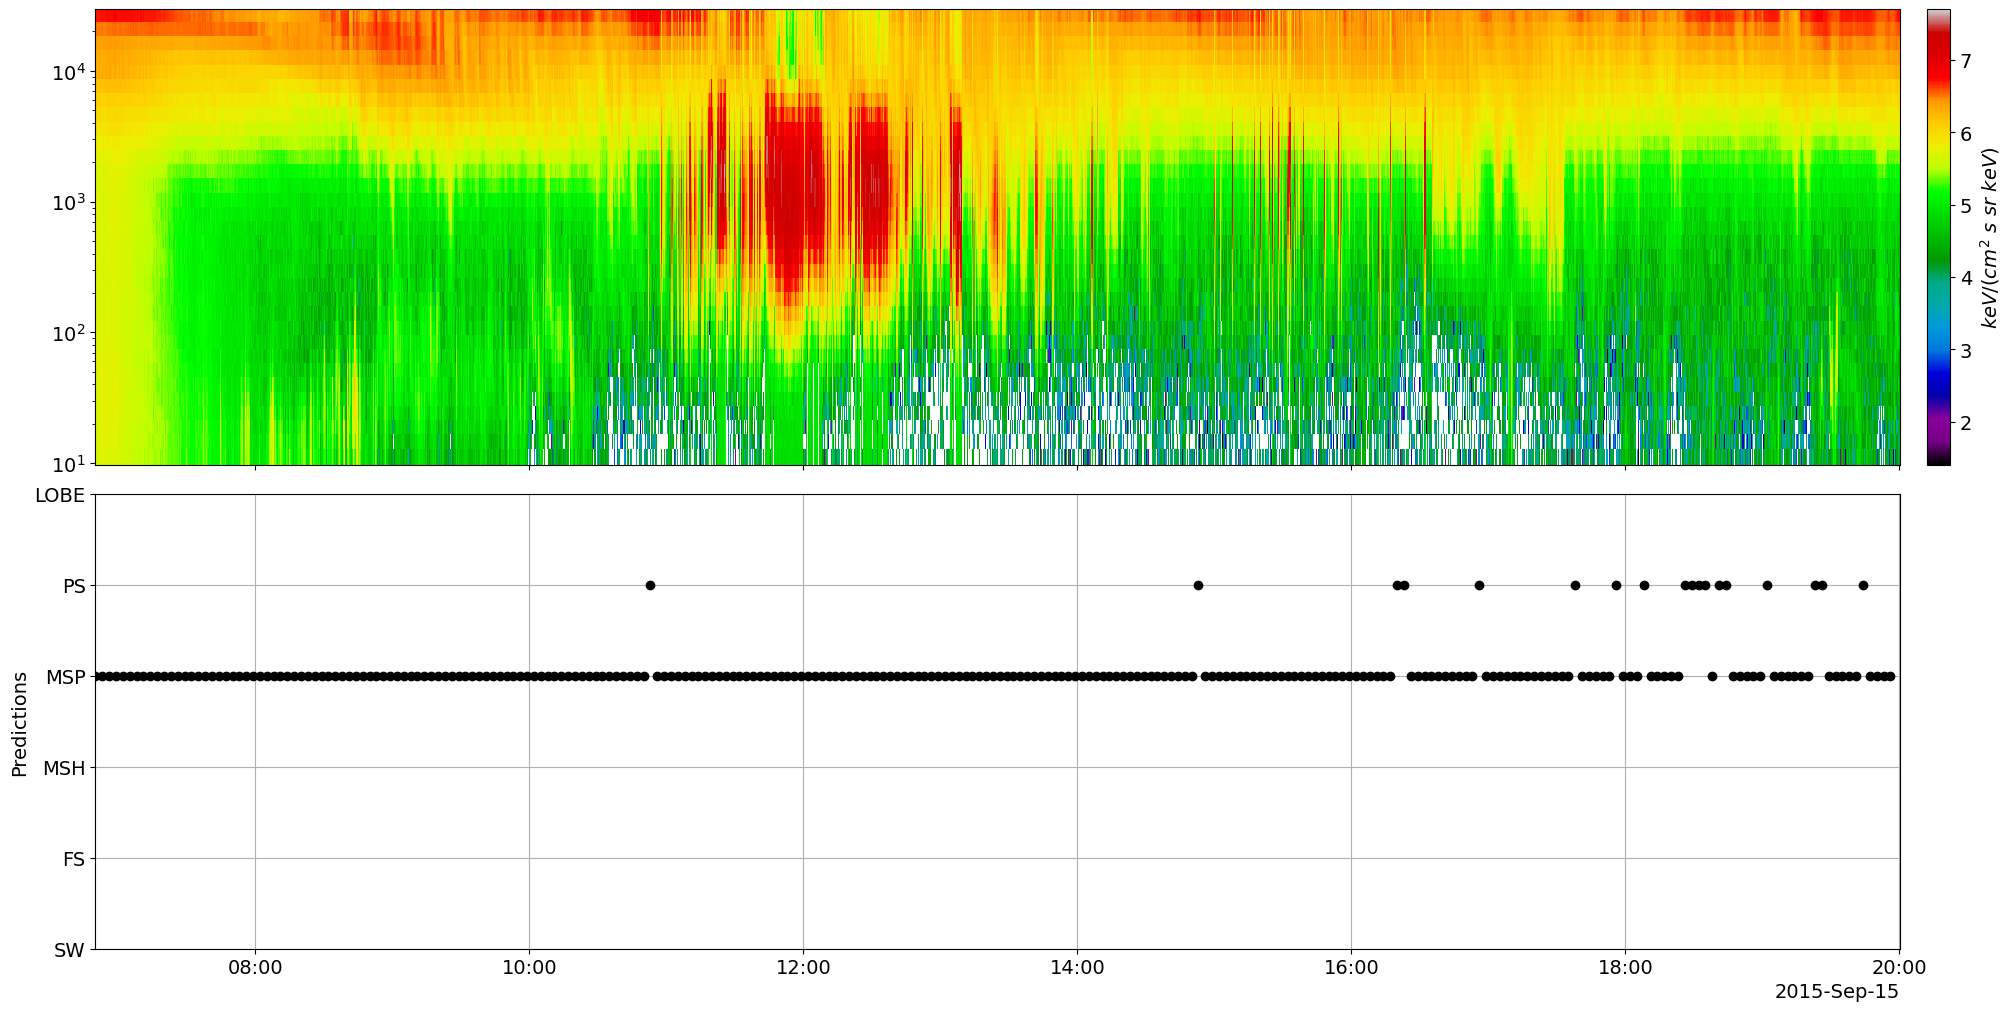

In [57]:
figure, axis = plt.subplots(2, 1,  figsize=(20, 10), sharex=True, constrained_layout=True) #sharex=True
pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0], np.log10(np.transpose(omni_flux.y[:,:])), cmap='nipy_spectral',shading='auto')
# pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0], np.transpose(omni_flux.y[:,:]), cmap='nipy_spectral',shading='auto')
axis[0].set_yscale('log')
figure.colorbar(pcm, ax=axis[0], label="$keV/(cm^2~s~sr~keV)$", pad=0)
# pcm.set_clim(3,6)

size=14
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size+2)    # legend fontsize
plt.rc('figure', titlesize=size)  # fontsize of the figure title


axis[1].plot(index, y_pred_tensor, 'ok')
axis[1].yaxis.set_ticks(np.arange(0,6,1))
axis[1].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE'])
axis[1].grid()
axis[1].set_ylabel('Predictions')
# axis[1].set_xlabel('time (UTC)')


# plt.savefig("FigCase_"+tname+".png")
plt.show()